# Scaling for the ACCESS-OM3 Regional 4km Configuration

## Overview
This notebook describes the setup and steps for conducting scaling analyses of the ACCESS-OM3 regional 4km configuration (panan 4km). The goal is to evaluate performance across different processor layouts for all runphase components using [experiment-generator](https://github.com/ACCESS-NRI/access-experiment-generator), [experiment-runner](https://github.com/ACCESS-NRI/access-experiment-runner) to generate experiment branches and run experiments, then using [esmf-trace](https://github.com/ACCESS-NRI/esmf-trace) postprocesses the runtime profiling/scaling afterwards.


## Model configuration
### Repo
https://github.com/claireyung/access-om3-configs @dev-MC_4km_jra_ryf+regionalpanan

## Experiment generation 

### [experiment-generator](https://github.com/ACCESS-NRI/access-experiment-generator)

Below is the yaml plan to generate experiment branches using experiment-generator,
```yaml
model_type: access-om3
repository_url: git@github.com:claireyung/access-om3-configs.git
start_point: "c6ab817" # Control commit hash for new branches
test_path: "." # All control and perturbation experiment repositories will be created here; can be relative, absolute or ~ (user-defined)
repository_directory: panan_4km_only # Local directory name for the central repository (user-defined)
control_branch_name: ctrl
Control_Experiment:

Perturbation_Experiment:
  Parameter_block_panan_4km_all1:
    branches: ['panan_4km_only_1', 'panan_4km_only_2', 'panan_4km_only_3', 'panan_4km_only_4', 'panan_4km_only_5', 'panan_4km_only_6', 'panan_4km_only_7', 'panan_4km_only_8', 'panan_4km_only_9', 'panan_4km_only_10', 'panan_4km_only_11']

    MOM_input:
      RESTART_CHECKSUMS_REQUIRED: false
      AUTO_IO_LAYOUT_FAC: REMOVE

    config.yaml:
      project: REMOVE
      shortpath: REMOVE

      env:
        ESMF_RUNTIME_PROFILE: "on"
        ESMF_RUNTIME_TRACE: "on"
        ESMF_RUNTIME_TRACE_PETLIST: ['0 104', '0 520', '0 936', '0 1352', '0 1768', '0 2184', '0 2600', '0 3016', '0 3432', '0 3848', '0 4264']
        ESMF_RUNTIME_PROFILE_OUTPUT: "SUMMARY"

      ncpus: [156, 624, 1092, 1560, 2028, 2496, 2964, 3432, 3900, 4368, 4836]
      mem: ['1000GB', '3000GB', '5500GB', '7500GB', '10000GB', '12000GB', '14500GB', '16500GB', '19000GB', '21000GB', '23500GB']
      walltime: ['10:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00', '5:00:00']


      metadata:
        enable: true

      # repeat: True

    nuopc.runconfig:
      PELAYOUT_attributes:
        atm_ntasks: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
        cpl_ntasks: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
        ice_ntasks: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
        ocn_ntasks: [104, 520, 936, 1352, 1768, 2184, 2600, 3016, 3432, 3848, 4264]
        ocn_rootpe: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
        rof_ntasks: [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]

      CLOCK_attributes:
        restart_n: 2
        restart_option: ndays
        stop_n: 2
        stop_option: ndays

```
This setup automatically generates 11 perturbation branches under the directory `panan_4km_only/` corresponding to increasing processor counts. Each branch represents a distinct processor layout and will be used for scaling tests. Because profiling is performed with `esmf-trace`, only 2 model days are simulated per run. This short duration drastically reduces runtime cost while still providing reliable timing statistics - ideal especially for higher-res (4 km) cases.

### Runtime trace configuration in payu setup
For profiling, we enable `ESMF` runtime tracing and profiling summary output. Only the first PET (processor) of each component - plus the starting PET for the ocean component — is traced. This selection targets the most computationally loaded processors, which tend to represent real runtime performance most accurately.

Below is the corresponding environment configuration:
```yaml
      env:
        ESMF_RUNTIME_PROFILE: "on"
        ESMF_RUNTIME_TRACE: "on"
        ESMF_RUNTIME_TRACE_PETLIST: ['0 104', '0 520', '0 936', '0 1352', '0 1768', '0 2184', '0 2600', '0 3016', '0 3432', '0 3848', '0 4264']
        ESMF_RUNTIME_PROFILE_OUTPUT: "SUMMARY"
```

- For example, in the first perturbation (`panan_4km_only_1`), the ICE, ATM, ROF, and MED components share the first 52 cores and run sequentially.
- The OCN component runs concurrently on 104 cores.
- The PET `0` (for sequential components) and `104` (first ocean PET) are traced for subsequent detailed analysis.
- A summary text output file will also be saved to give an overview of how each run performs.

### Running Experiments with [experiment-runner](https://github.com/ACCESS-NRI/access-experiment-runner)
The experiments are executed using the ACCESS Experiment-Runner. Below is the yaml plan,
```yaml
test_path: /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3 # All control and perturbation experiment repositories.
repository_directory: panan_4km_only # Local directory name for the central repository, where the running_branches are forked from.
keep_uuid: True
# ================= 1 =================
running_branches: ['panan_4km_only_1', 'panan_4km_only_2', 'panan_4km_only_3', 'panan_4km_only_4', 'panan_4km_only_5', 'panan_4km_only_6', 'panan_4km_only_7', 'panan_4km_only_8', 'panan_4km_only_9', 'panan_4km_only_10', 'panan_4km_only_11']

nruns: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


startfrom_restart: ['cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold']

```
Each experiment runs once and starts from a cold start, ensuring reproducibility and independent scaling measurements.

## Postprocessing trace timeseries

### 

In [1]:
from access.esmf_trace.tmp_yaml_parser import read_yaml, write_yaml
from access.esmf_trace.postprocess import _norm_model_component
import pandas as pd
from pathlib import Path

import re
import numpy as np
import matplotlib.pyplot as plt

## Gnenerate run-config.yaml for subcommand run-from-yaml

In [2]:
DEFAULTS = {
    "stream_prefix": "esmf_stream",
    # "max_workers": 48, # can be auto-determined based on the applied cores
    "xaxis_datetime": False,
    "separate_plots": False,
    "cmap": "tab10",
    "renderer": "browser",
    "show_html": False,
}

def gen_run_config(
    *,
    post_base_path: str,
    model_component: str,
    base_prefix: str,
    count: int,
    list_pets: list[str],
    list_exact_path: list[str],
):
    runs = []
    for i in range(1, count + 1):
        name = f"{base_prefix}_{i}"
        r = {
            "base_prefix": name,
            "pets": list_pets[i-1],
        }

        r["exact_path"] = list_exact_path[i-1]

        runs.append(r)

    return {
        "default_settings": {
            "post_base_path": post_base_path,
            "model_component": model_component,
            "max_workers": 12, # default workers dont run on login node. 
            **DEFAULTS
        },
        "runs": runs,
    }

## Gnenerate postprocessing-config.yaml for subcommand post-summary-from-yaml

In [3]:
DEFAULTS = {
    "stream_prefix": "esmf_stream",
    "timeseries_suffix": "_timeseries.json",
}

def gen_postprocessing_config(
    *,
    post_prefix: str = "postprocessing",
    base_prefix: str,
    model_component: str | list[str],
    post_base_path: str,
    count: int,
    save_json_path: str,
    list_pets: list[str],
    stats_start_index: int,
    stats_end_index: int,
):
    runs = []
    for i in range(1, count + 1):
        name = f"{post_prefix}_{base_prefix}_{i}"
        r = {
            "name": name,
            "pets": list_pets[i-1],
        }
        runs.append(r)

    return {
        "default_settings": {
            "post_base_path": post_base_path,
            "model_component": model_component,
            "save_json_path": save_json_path,
            "stats_start_index": stats_start_index,
            "stats_end_index": stats_end_index,
            **DEFAULTS
        },
        "runs": runs,
    }

## plot for scaling

In [43]:
plt.rcParams.update({
    "font.size": 15,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 15,
})

def _extract_component_from_name(base_prefix, name):
    s = str(name)
    if "/output" in s or "/combine/" in s:
        after = s.split("/", 1)[1]
        parts = after.split("/", 1)
        return parts[1] if len(parts) > 1 else None
    return None

def _filter_by_components_index(stats_df, base_prefix, comps):
    if not comps:
        return stats_df
    wanted = {c.strip() for c in comps}
    idx = stats_df.index.to_series()
    keep = idx.map(lambda nm: (_extract_component_from_name(base_prefix, str(nm)) or "").strip() in wanted)
    return stats_df[keep]

def _parse_name_index(base_prefix, name):
    s = str(name)
    if "/output" in s:
        after = s.split("/", 1)[1]
        output_name = after.split("/", 1)[0]
    elif "/combine/" in s:
        output_name = "combine"
    else:
        output_name = None
    m = re.search(rf"{re.escape(base_prefix)}_(\d+)", s)
    if not m:
        head = s.split("/", 1)[0]
        m = re.search(r"_(\d+)(?:$|[_/])", head)
    case_id = int(m.group(1)) if m else None
    return case_id, output_name

def _build_pivot(stats_df, base_prefix, cores, ycol, outputs, aggfunc="mean"):
    df = stats_df.copy()
    parsed = df.index.to_series().map(lambda s: _parse_name_index(base_prefix, str(s)))
    df["__case_id"] = parsed.map(lambda t: t[0])
    df["__output_name"] = parsed.map(lambda t: t[1])
    df = df[df["__output_name"].isin(outputs)].copy()

    order = df["__case_id"].copy()
    df["__order"] = order.astype(int)
    df = df.sort_values(["__order", "__output_name"], kind="mergesort")

    piv = df.pivot_table(index="__order", columns="__output_name", values=ycol, aggfunc=aggfunc).sort_index()
    for col in outputs:
        if col not in piv.columns:
            piv[col] = np.nan
    piv = piv.loc[:, list(outputs)]

    piv.index = pd.Index(cores, name="cores")
    x = piv.index.to_numpy(dtype=float)
    return piv, x

def _style_axes_with_top_index(ax, x, logx=False, logy=False, xlabel="Cores", top_label="Index", rotate=45):
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    ax.set_xticks(x)
    ax.set_xticklabels([str(int(v)) for v in x], rotation=rotate)
    ax.set_xlabel(xlabel)
    ax2 = ax.twiny()
    if logx:
        ax2.set_xscale("log")
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(i) for i in range(len(x))], rotation=rotate)
    ax2.set_xlabel(top_label)
    return ax2

def plot_scaling(stats_df: pd.DataFrame,
                 base_prefix: str,
                 cores: list[int],
                 ycol: str = "tmedian",
                 outputs: tuple[str, ...] = ("combine",),
                 output_for_ideal: str = "combine",
                 ideal_ref_index: int = 1,
                 title: str = "Strong scaling",
                 ylabel: str | None = None,
                 figsize: tuple[int, int] = (20, 6),
                 loglog: bool = True,
                 model_component: str | list[str] | None = None,
                 subplot_by_component: bool = False,
                 subplot_nrow: int | None = None,
                 subplot_ncol: int | None = None,
                 ylim = None,
                 new_vars: dict[str, list[str]] | None = None,
                 ):

    comps = []
    comp_labels = []

    mc = _norm_model_component(model_component)
    if mc:
        # explicit model components
        comps.extend(mc)
        comp_labels.extend([c.split("/")[-1] for c in mc])

    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                raise ValueError(f"-- new_var '{new_name}' has no components!")
            # keep the group of parts together under one label
            comps.append(parts_norm)
            comp_labels.append(new_name)

    if not comps:
        comps = [None]
        comp_labels = ["(all)"]

    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
    
        fig, axes = plt.subplots(
            subplot_nrow, subplot_ncol,
            figsize=(figsize[0], figsize[1]),
            # sharex=True,
            #sharey=True
        )
        axes = np.array(axes).flatten()
    
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])  # unified interface

    pivot_blocks, keys = [], []
    x_all = np.asarray(cores, dtype=float)

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]

        if comp is None: # (all)
            df_use = stats_df
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [comp])
        aggfunc = "sum" if isinstance(comp, (list, tuple, set)) else "mean"
        if isinstance(df_use, pd.DataFrame) and df_use.empty:
            print(f"-- No data found for model_component='{comp}'. Skipping.")
            continue

        pivot, x = _build_pivot(df_use, base_prefix, cores, ycol, outputs, aggfunc=aggfunc)

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            req = [o for o in outputs if str(o).startswith("output")]
            piv_o, _ = _build_pivot(df_use, base_prefix, cores, ycol, tuple(req), aggfunc=aggfunc)
            present = [c for c in req if c in piv_o.columns]
            if present:
                pivot["combine"] = piv_o[present].sum(axis=1, skipna=True)

        # Plot each selected output
        for out in outputs:
            if out not in pivot.columns:
                continue
            y = pivot[out].to_numpy(dtype=float)

            if loglog:
                mask = np.isfinite(x_all) & (x_all > 0) & np.isfinite(y) & (y > 0)
            else:
                mask = np.isfinite(x_all) & np.isfinite(y)
            if not mask.any():
                continue

            x_plot, y_plot = x_all[mask], y[mask]
            label = (short_lbl if not subplot_by_component or len(comps) == 1 else out)
            line, = ax.plot(x_plot, y_plot, "o-", linewidth=1.2, markersize=3, label=label)

            if out == output_for_ideal and (0 <= ideal_ref_index < len(x_plot)):
                y0, x0 = y_plot[ideal_ref_index], x_plot[ideal_ref_index]
                ax.plot(x_plot, y0 * (x0 / x_plot), "--", linewidth=1.0, color=line.get_color(),
                        label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal"))

        if loglog:
            ax.set_xscale("log")
            ax.set_yscale("log")

        _ = _style_axes_with_top_index(ax, x_all, logx=loglog, logy=loglog, xlabel="Cores", top_label="Index", rotate=45)
        if subplot_by_component and len(comps) > 1:
            ax.set_title(short_lbl)

        pivot_blocks.append(pivot)
        keys.append(short_lbl if (comp is not None) else "(all)")

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict):
                key = short_lbl if short_lbl in ylim else "(all)"
                if key in ylim:
                    ax.set_ylim(*ylim[key])

    axes[0].set_ylabel(ylabel or ycol)
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if not h:
            continue
        uniq = dict(zip(l, h))
        ax.legend(uniq.values(), uniq.keys(), ncol=2)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    pivot_summary = pd.concat(pivot_blocks, axis=1, keys=keys)
    pivot_summary.index = pd.Index(cores, name="cores")
    return pivot_summary

def plot_speedup(stats_df: pd.DataFrame,
                 base_prefix: str,
                 cores: list[int],
                 ycol: str = "tmedian",
                 outputs: tuple[str, ...] = ("combine",),
                 output_for_ideal: str = "combine",
                 ideal_ref_index: int = 1,
                 title: str = "Speedup",
                 ylabel: str | None = "Speedup",
                 figsize: tuple[int, int] = (20, 6),
                 loglog: bool = True,
                 model_component: str | list[str] | None = None,
                 subplot_by_component: bool = False,
                 subplot_nrow: int | None = None,
                 subplot_ncol: int | None = None,
                 ylim=None,
                 new_vars: dict[str, list[str]] | None = None,
                 ):
    """
    Speedup S(n) = T_ref / T(n).
    Ideal: S_ideal(n) = n / n_ref.
    """

    comps = []
    comp_labels = []

    mc = _norm_model_component(model_component)
    if mc:
        # explicit model components
        comps.extend(mc)
        comp_labels.extend([c.split("/")[-1] for c in mc])

    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                raise ValueError(f"-- new_var '{new_name}' has no components!")
            # keep the group of parts together under one label
            comps.append(parts_norm)
            comp_labels.append(new_name)
    
    # If nothing specified at all, fall back to (all)
    if not comps:
        comps = [None]
        comp_labels = ["(all)"]

    # figure/axes
    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=(figsize[0], figsize[1]))
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    x_all = np.asarray(cores, dtype=float)
    metric_blocks, keys = [], []

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]
        if comp is None:
            df_use = stats_df
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [comp])
        if isinstance(df_use, pd.DataFrame) and df_use.empty:
            print(f"-- No data found for model_component='{comp}'. Skipping.")
            continue

        pivot, _ = _build_pivot(df_use, base_prefix, cores, ycol, outputs, aggfunc="mean")

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            req = [o for o in outputs if str(o).startswith("output")]
            piv_o, _ = _build_pivot(df_use, base_prefix, cores, ycol, tuple(req), aggfunc="mean")
            present = [c for c in req if c in piv_o.columns]
            if present:
                pivot["combine"] = piv_o[present].mean(axis=1, skipna=True)

        metric_df = pd.DataFrame(index=pd.Index(cores, name="cores"),
                                 columns=list(outputs), dtype=float)
        # plot
        for out in outputs:
            if out not in pivot.columns:
                continue
            t = pivot[out].to_numpy(dtype=float)  # times
            if loglog:
                mask = np.isfinite(x_all) & (x_all > 0) & np.isfinite(t) & (t > 0)
            else:
                mask = np.isfinite(x_all) & np.isfinite(t)
            if not mask.any():
                continue

            idxs = np.where(mask)[0]
            x_plot, t_plot = x_all[mask], t[mask]
            if not (0 <= ideal_ref_index < len(t_plot)):
                continue
            t_ref = t_plot[ideal_ref_index]
            n_ref = x_plot[ideal_ref_index]

            y_speedup = t_ref / t_plot  # S(n)

            metric_df.iloc[idxs, metric_df.columns.get_loc(out)] = y_speedup

            label = (short_lbl if not subplot_by_component or len(comps) == 1 else out)
            line, = ax.plot(x_plot, y_speedup, "o-", linewidth=1.2, markersize=3, label=label)

            # ideal line: n / n_ref
            ax.plot(x_plot, x_plot / n_ref, "--", linewidth=1.0, color=line.get_color(),
                    label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal"))

        if loglog:
            ax.set_xscale("log"); ax.set_yscale("log")
        _ = _style_axes_with_top_index(ax, x_all, logx=loglog, logy=loglog, xlabel="Cores", top_label="Index", rotate=45)
        if subplot_by_component and len(comps) > 1:
            ax.set_title(short_lbl)

        metric_blocks.append(metric_df)
        keys.append(short_lbl if (comp is not None) else "(all)")

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict):
                key = short_lbl if short_lbl in ylim else "(all)"
                if key in ylim:
                    ax.set_ylim(*ylim[key])

    axes[0].set_ylabel(ylabel or "Speedup (×)")
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    speedup_summary = pd.concat(metric_blocks, axis=1, keys=keys)
    return speedup_summary

def plot_efficiency(stats_df: pd.DataFrame,
                    base_prefix: str,
                    cores: list[int],
                    ycol: str = "tmedian",
                    outputs: tuple[str, ...] = ("combine",),
                    output_for_ideal: str = "combine",
                    ideal_ref_index: int = 1,
                    title: str = "Parallel efficiency",
                    ylabel: str | None = "Efficiency",
                    figsize: tuple[int, int] = (20, 6),
                    loglog: bool = False,
                    model_component: str | list[str] | None = None,
                    subplot_by_component: bool = False,
                    subplot_nrow: int | None = None,
                    subplot_ncol: int | None = None,
                    ylim=None,
                    new_vars: dict[str, list[str]] | None = None,
                    ):
    """
    Efficiency eta(n) = S(n) * (n_ref / n) = (T_ref * n_ref) / (T(n) * n).
    Ideal: eta_ideal = 1 (flat line).
    """

    comps = []
    comp_labels = []

    mc = _norm_model_component(model_component)
    if mc:
        # explicit model components
        comps.extend(mc)
        comp_labels.extend([c.split("/")[-1] for c in mc])

    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                raise ValueError(f"-- new_var '{new_name}' has no components!")
            # keep the group of parts together under one label
            comps.append(parts_norm)
            comp_labels.append(new_name)
    
    # If nothing specified at all, fall back to (all)
    if not comps:
        comps = [None]
        comp_labels = ["(all)"]

    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=(figsize[0], figsize[1]))
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    x_all = np.asarray(cores, dtype=float)
    metric_blocks, keys = [], []

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]
        if comp is None:
            df_use = stats_df
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [comp])
        if isinstance(df_use, pd.DataFrame) and df_use.empty:
            print(f"-- No data found for model_component='{comp}'. Skipping.")
            continue

        pivot, _ = _build_pivot(df_use, base_prefix, cores, ycol, outputs, aggfunc="mean")

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            req = [o for o in outputs if str(o).startswith("output")]
            piv_o, _ = _build_pivot(df_use, base_prefix, cores, ycol, tuple(req), aggfunc="mean")
            present = [c for c in req if c in piv_o.columns]
            if present:
                pivot["combine"] = piv_o[present].mean(axis=1, skipna=True)

        metric_df = pd.DataFrame(index=pd.Index(cores, name="cores"),
                                 columns=list(outputs), dtype=float)

        for out in outputs:
            if out not in pivot.columns:
                continue
            t = pivot[out].to_numpy(dtype=float)

            if loglog:
                mask = np.isfinite(x_all) & (x_all > 0) & np.isfinite(t) & (t > 0)
            else:
                mask = np.isfinite(x_all) & np.isfinite(t)
            if not mask.any():
                continue

            idxs = np.where(mask)[0]
            x_plot, t_plot = x_all[mask], t[mask]
            if not (0 <= ideal_ref_index < len(t_plot)):
                continue
            t_ref = t_plot[ideal_ref_index]
            n_ref = x_plot[ideal_ref_index]

            eta = (t_ref * n_ref) / (t_plot * x_plot)

            metric_df.iloc[idxs, metric_df.columns.get_loc(out)] = eta

            label = (short_lbl if not subplot_by_component or len(comps) == 1 else out)
            line, = ax.plot(x_plot, eta, "o-", linewidth=1.2, markersize=3, label=label)

            ax.axhline(1.0, linestyle="--", linewidth=1.0, color=line.get_color(),
                       label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal"))

        if loglog:
            ax.set_xscale("log"); ax.set_yscale("log")
        _ = _style_axes_with_top_index(ax, x_all, logx=loglog, logy=loglog, xlabel="Cores", top_label="Index", rotate=45)
        if subplot_by_component and len(comps) > 1:
            ax.set_title(short_lbl)

        metric_blocks.append(metric_df)
        keys.append(short_lbl if (comp is not None) else "(all)")

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict):
                key = short_lbl if short_lbl in ylim else "(all)"
                if key in ylim:
                    ax.set_ylim(*ylim[key])

    axes[0].set_ylabel(ylabel or "Efficiency")
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    efficiency_summary = pd.concat(metric_blocks, axis=1, keys=keys)
    return efficiency_summary

## for the test panan_4km

In [5]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write,"
    "[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1"
)

suffix = "test_all_comp"
count=11
base_prefix="panan_4km_only"
branch="panan_4km_only"
pets=['0 104', '0 520', '0 936', '0 1352', '0 1768', '0 2184', '0 2600', '0 3016', '0 3432', '0 3848', '0 4264']
list_pets = [p.replace(' ', ',') for p in pets]

list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

In [6]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
    "[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
]
model_component = model_component

post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    list_pets=list_pets,
    save_json_path=save_json_path,
    stats_start_index=0,
    stats_end_index=None,
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

In [7]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")

# This is for data components
 - atm runphase1
 - rof runphase1

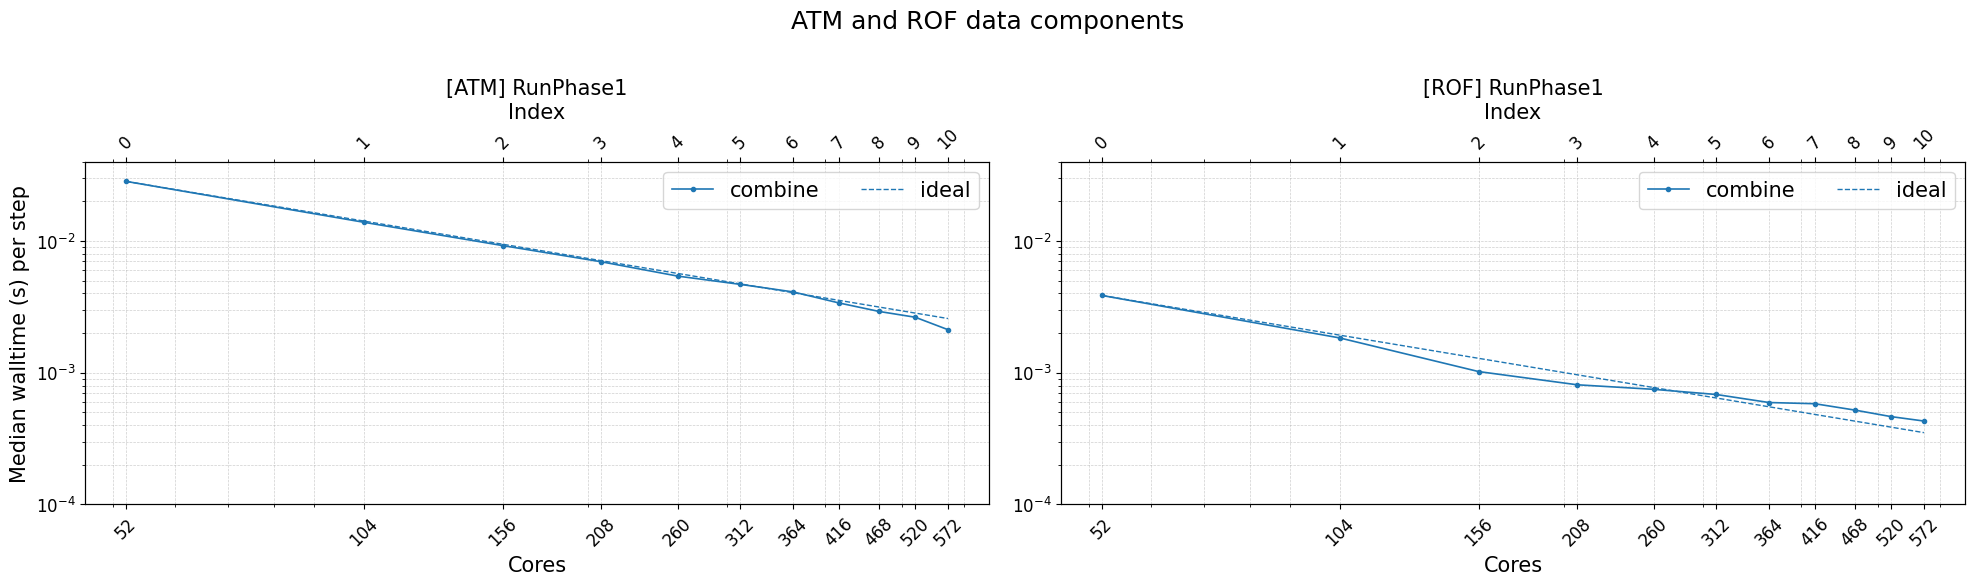

In [8]:
cores = [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1"
)

pivot_scaling_data_component = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Median walltime (s) per step",
    ylim=(1e-4,4e-2),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ATM and ROF data components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

In [9]:
pivot_scaling_data_component

[ATM] RunPhase1 [ROF] RunPhase1
__output_name         combine         combine
cores                                        
52                   0.028390        0.003861
104                  0.013896        0.001839
156                  0.009243        0.001021
208                  0.006963        0.000810
260                  0.005419        0.000748
312                  0.004691        0.000684
364                  0.004111        0.000594
416                  0.003391        0.000582
468                  0.002921        0.000520
520                  0.002639        0.000464
572                  0.002125        0.000430

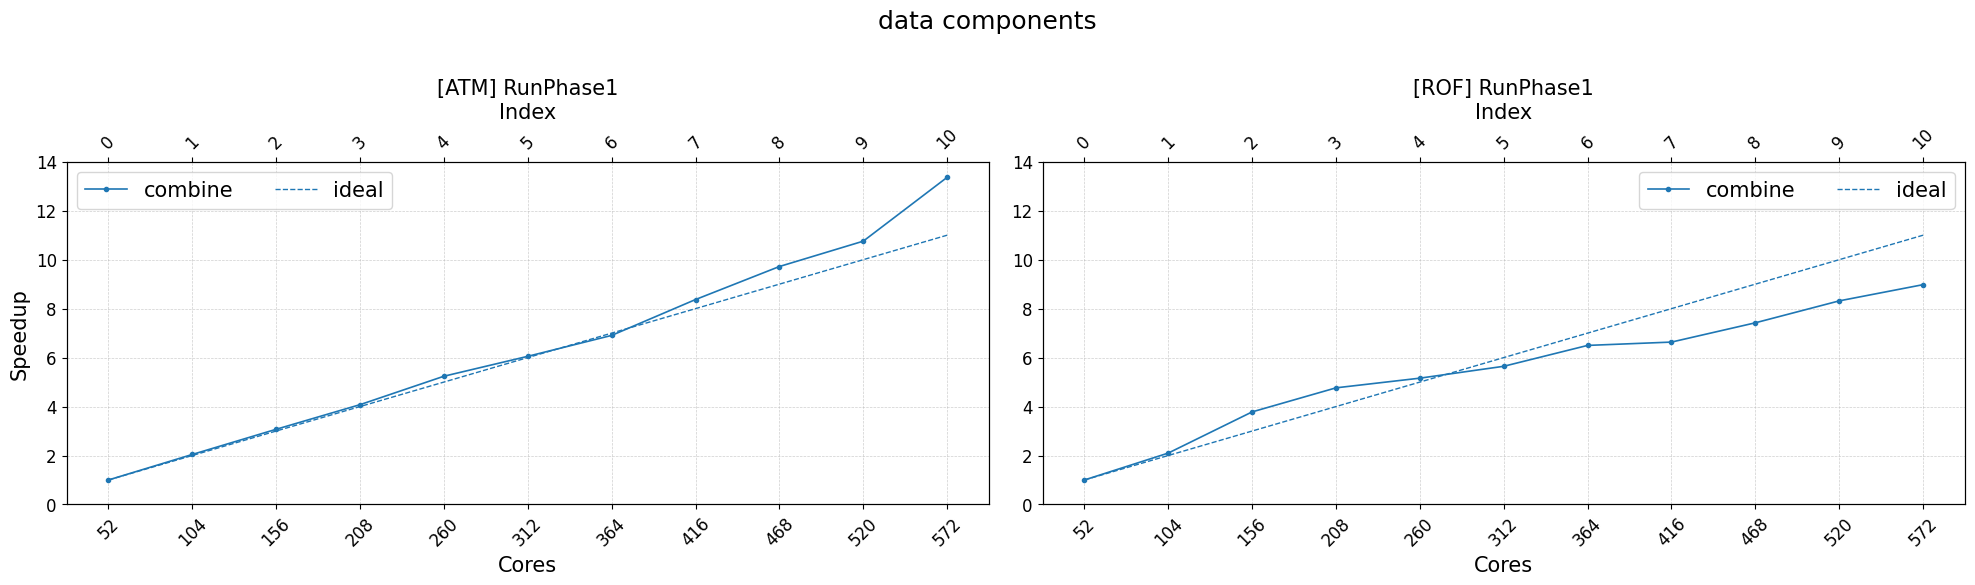

In [10]:
pivot_speedup_data_component = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0,14),
    loglog=False,
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="data components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

In [11]:
pivot_speedup_data_component

[ATM] RunPhase1 [ROF] RunPhase1
              combine         combine
cores                                
52           1.000000        1.000000
104          2.043019        2.099653
156          3.071533        3.781887
208          4.077564        4.764438
260          5.238570        5.159728
312          6.052046        5.644657
364          6.906292        6.497549
416          8.371062        6.633604
468          9.720283        7.421312
520         10.756240        8.317177
572         13.363080        8.979648

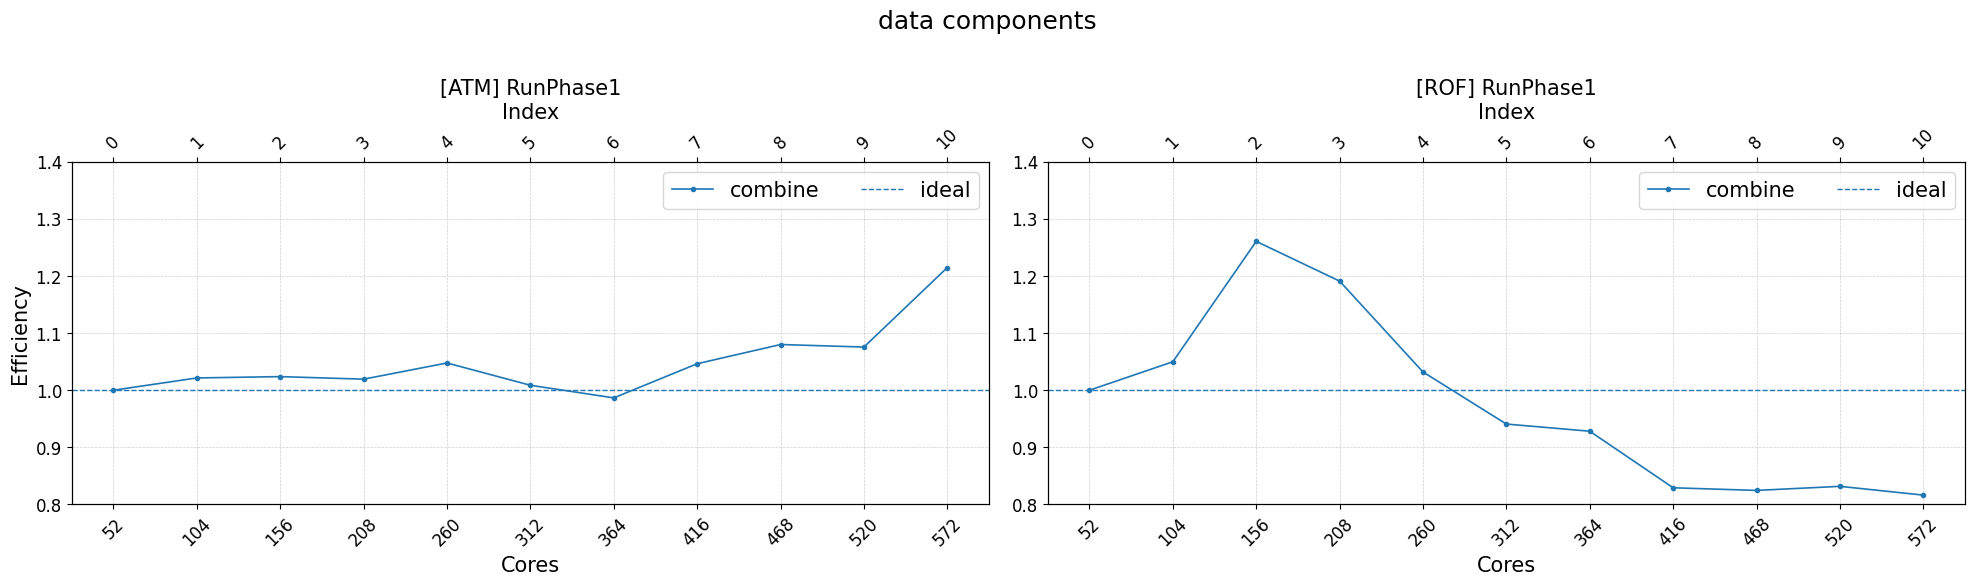

In [12]:
pivot_efficiency_data_component = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0.8,1.4),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="data components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

In [13]:
pivot_efficiency_data_component

[ATM] RunPhase1 [ROF] RunPhase1
              combine         combine
cores                                
52           1.000000        1.000000
104          1.021509        1.049826
156          1.023844        1.260629
208          1.019391        1.191109
260          1.047714        1.031946
312          1.008674        0.940776
364          0.986613        0.928221
416          1.046383        0.829200
468          1.080031        0.824590
520          1.075624        0.831718
572          1.214825        0.816332

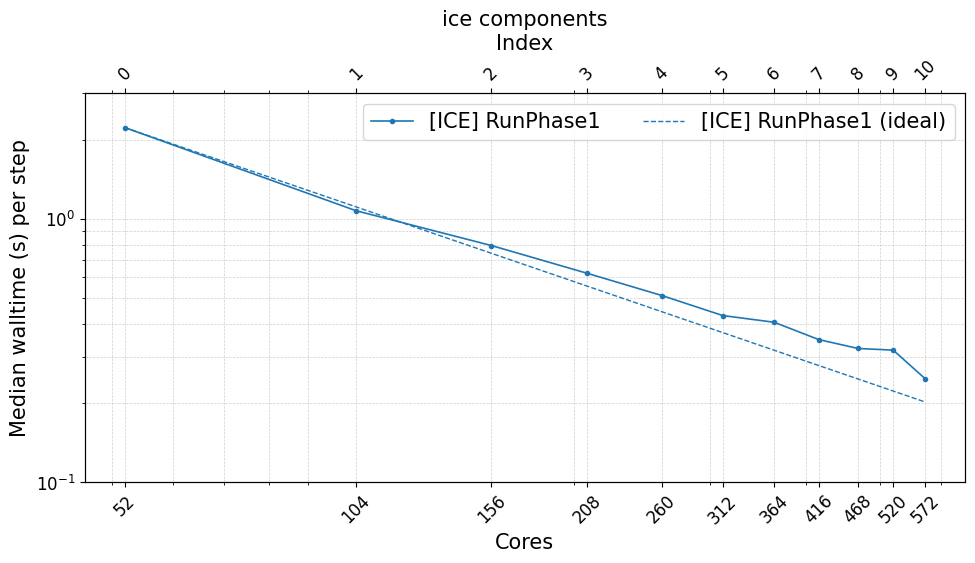

In [14]:
cores = [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1",
)

pivot_scaling_ice = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Median walltime (s) per step",
    ylim=(1e-1,3),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ice components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [15]:
pivot_scaling_ice

[ICE] RunPhase1
__output_name         combine
cores                        
52                   2.223217
104                  1.074912
156                  0.792909
208                  0.621786
260                  0.512307
312                  0.430091
364                  0.405507
416                  0.348610
468                  0.322495
520                  0.317832
572                  0.247963

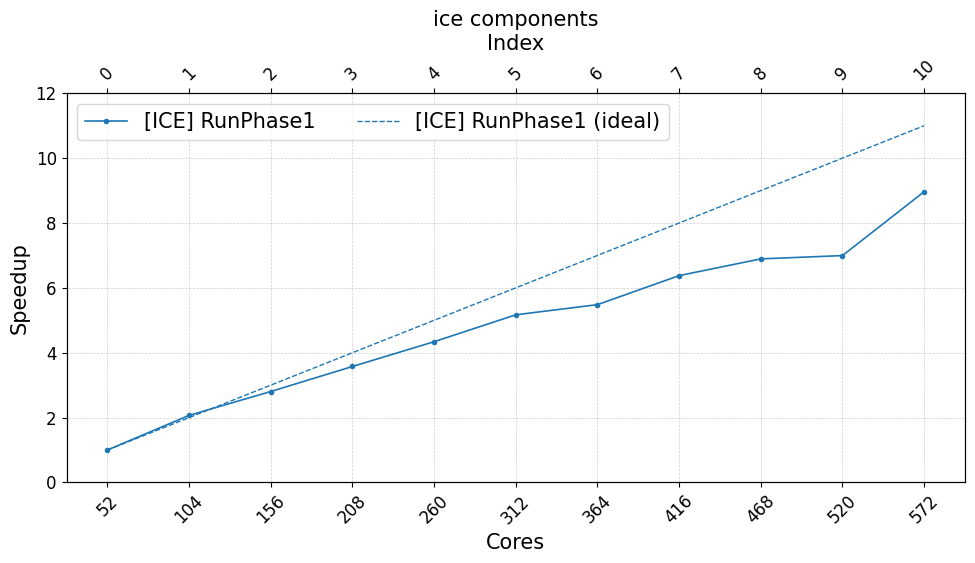

In [16]:
pivot_speedup_ice = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0,12),
    loglog=False,
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ice components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [17]:
pivot_speedup_ice

[ICE] RunPhase1
              combine
cores                
52           1.000000
104          2.068278
156          2.803874
208          3.575534
260          4.339621
312          5.169178
364          5.482566
416          6.377377
468          6.893794
520          6.994944
572          8.965939

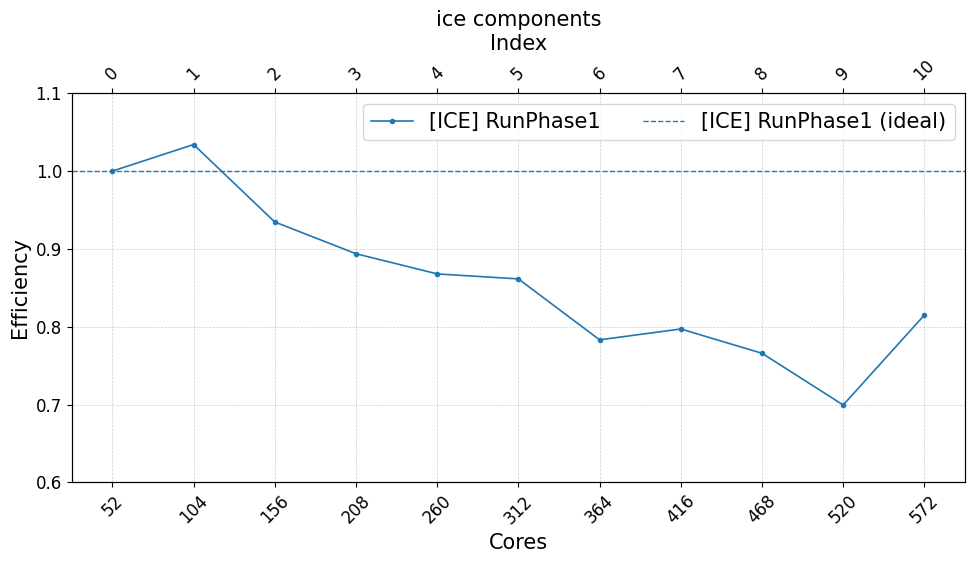

In [18]:
pivot_efficiency_ice = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0.6, 1.1),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ice components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [19]:
pivot_efficiency_ice

[ICE] RunPhase1
              combine
cores                
52           1.000000
104          1.034139
156          0.934625
208          0.893884
260          0.867924
312          0.861530
364          0.783224
416          0.797172
468          0.765977
520          0.699494
572          0.815085

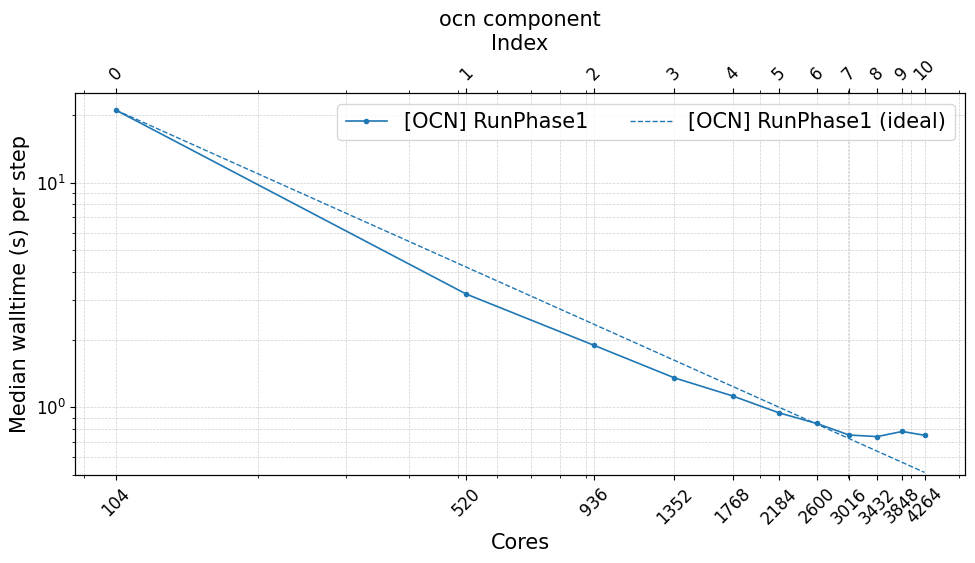

In [20]:
cores = [104, 520, 936, 1352, 1768, 2184, 2600, 3016, 3432, 3848, 4264]
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
)

pivot_scaling_ocn = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Median walltime (s) per step",
    ylim=(5e-1,25),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ocn component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [21]:
pivot_scaling_ocn

[OCN] RunPhase1
__output_name         combine
cores                        
104                 21.058545
520                  3.193890
936                  1.886957
1352                 1.353598
1768                 1.123822
2184                 0.946363
2600                 0.847967
3016                 0.753490
3432                 0.741260
3848                 0.781517
4264                 0.751327

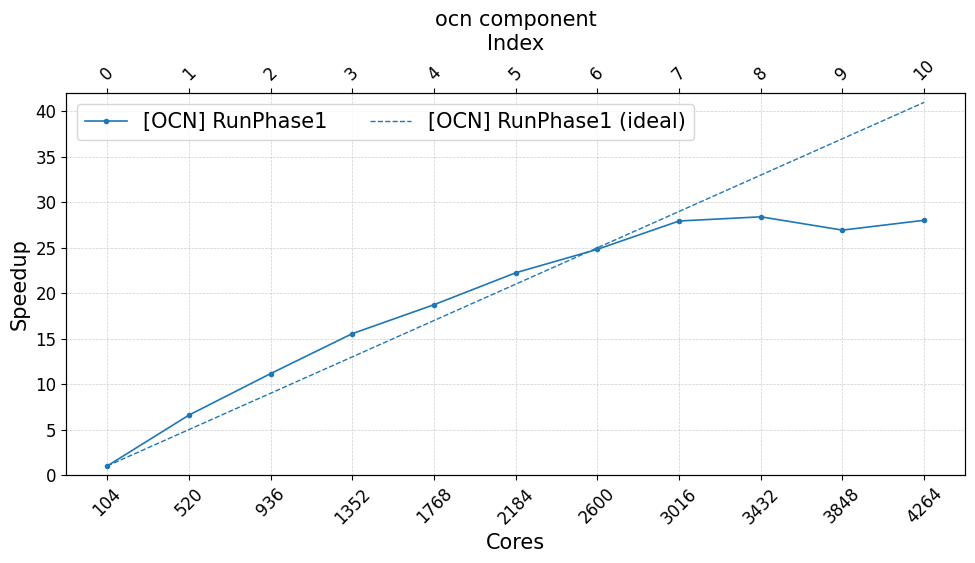

In [22]:
pivot_speedup_ocn = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0, 42),
    loglog=False,
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ocn component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [23]:
pivot_speedup_ocn

[OCN] RunPhase1
              combine
cores                
104          1.000000
520          6.593385
936         11.160057
1352        15.557455
1768        18.738332
2184        22.252069
2600        24.834149
3016        27.947998
3432        28.409119
3848        26.945720
4264        28.028461

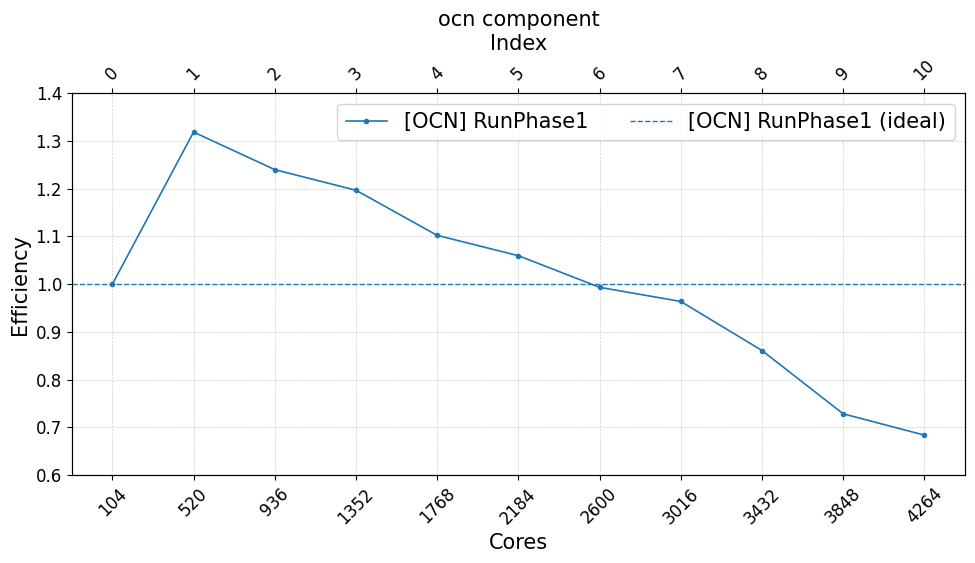

In [24]:
pivot_efficiency_ocn = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0.6, 1.4),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ocn component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [25]:
pivot_efficiency_ocn

[OCN] RunPhase1
              combine
cores                
104          1.000000
520          1.318677
936          1.240006
1352         1.196727
1768         1.102255
2184         1.059622
2600         0.993366
3016         0.963724
3432         0.860882
3848         0.728263
4264         0.683621

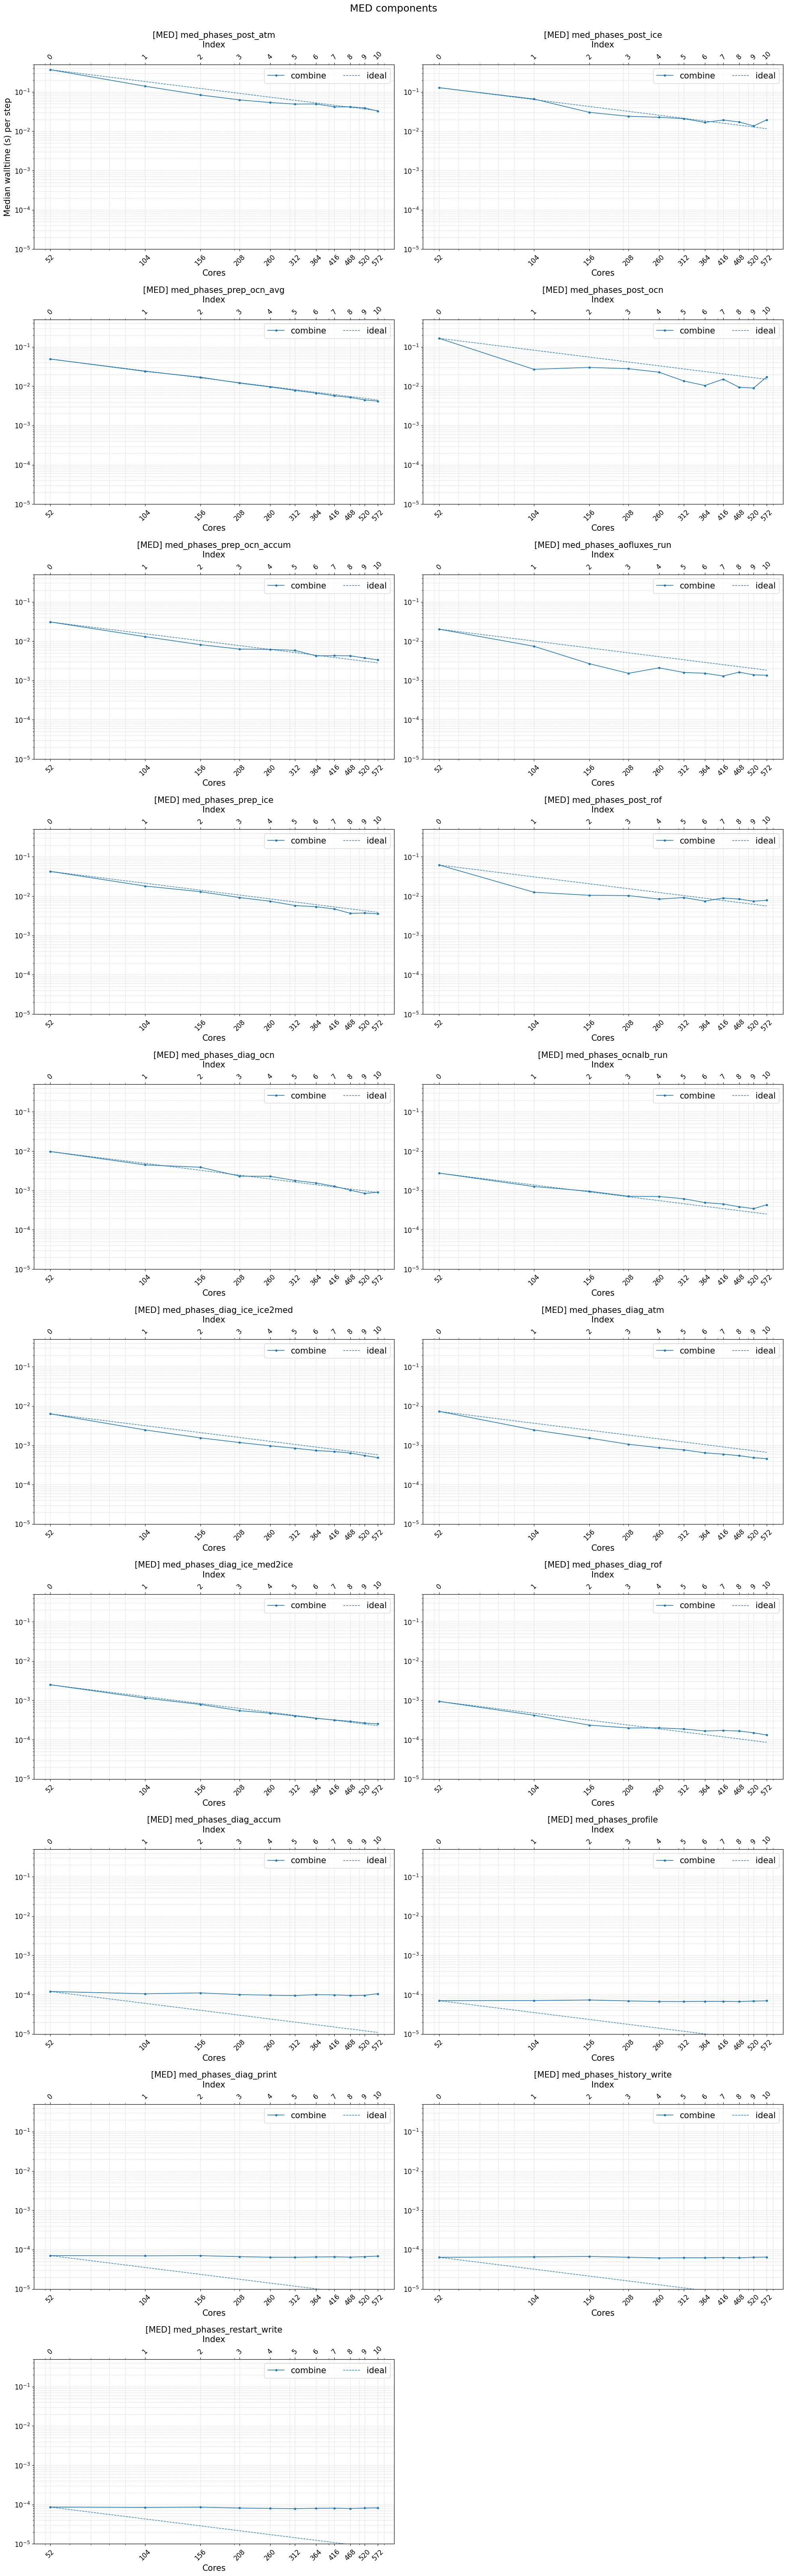

In [26]:
cores = [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write,"
)

pivot_scaling_med = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Median walltime (s) per step",
    ylim=(1e-5,0.5),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="MED components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,66)
)

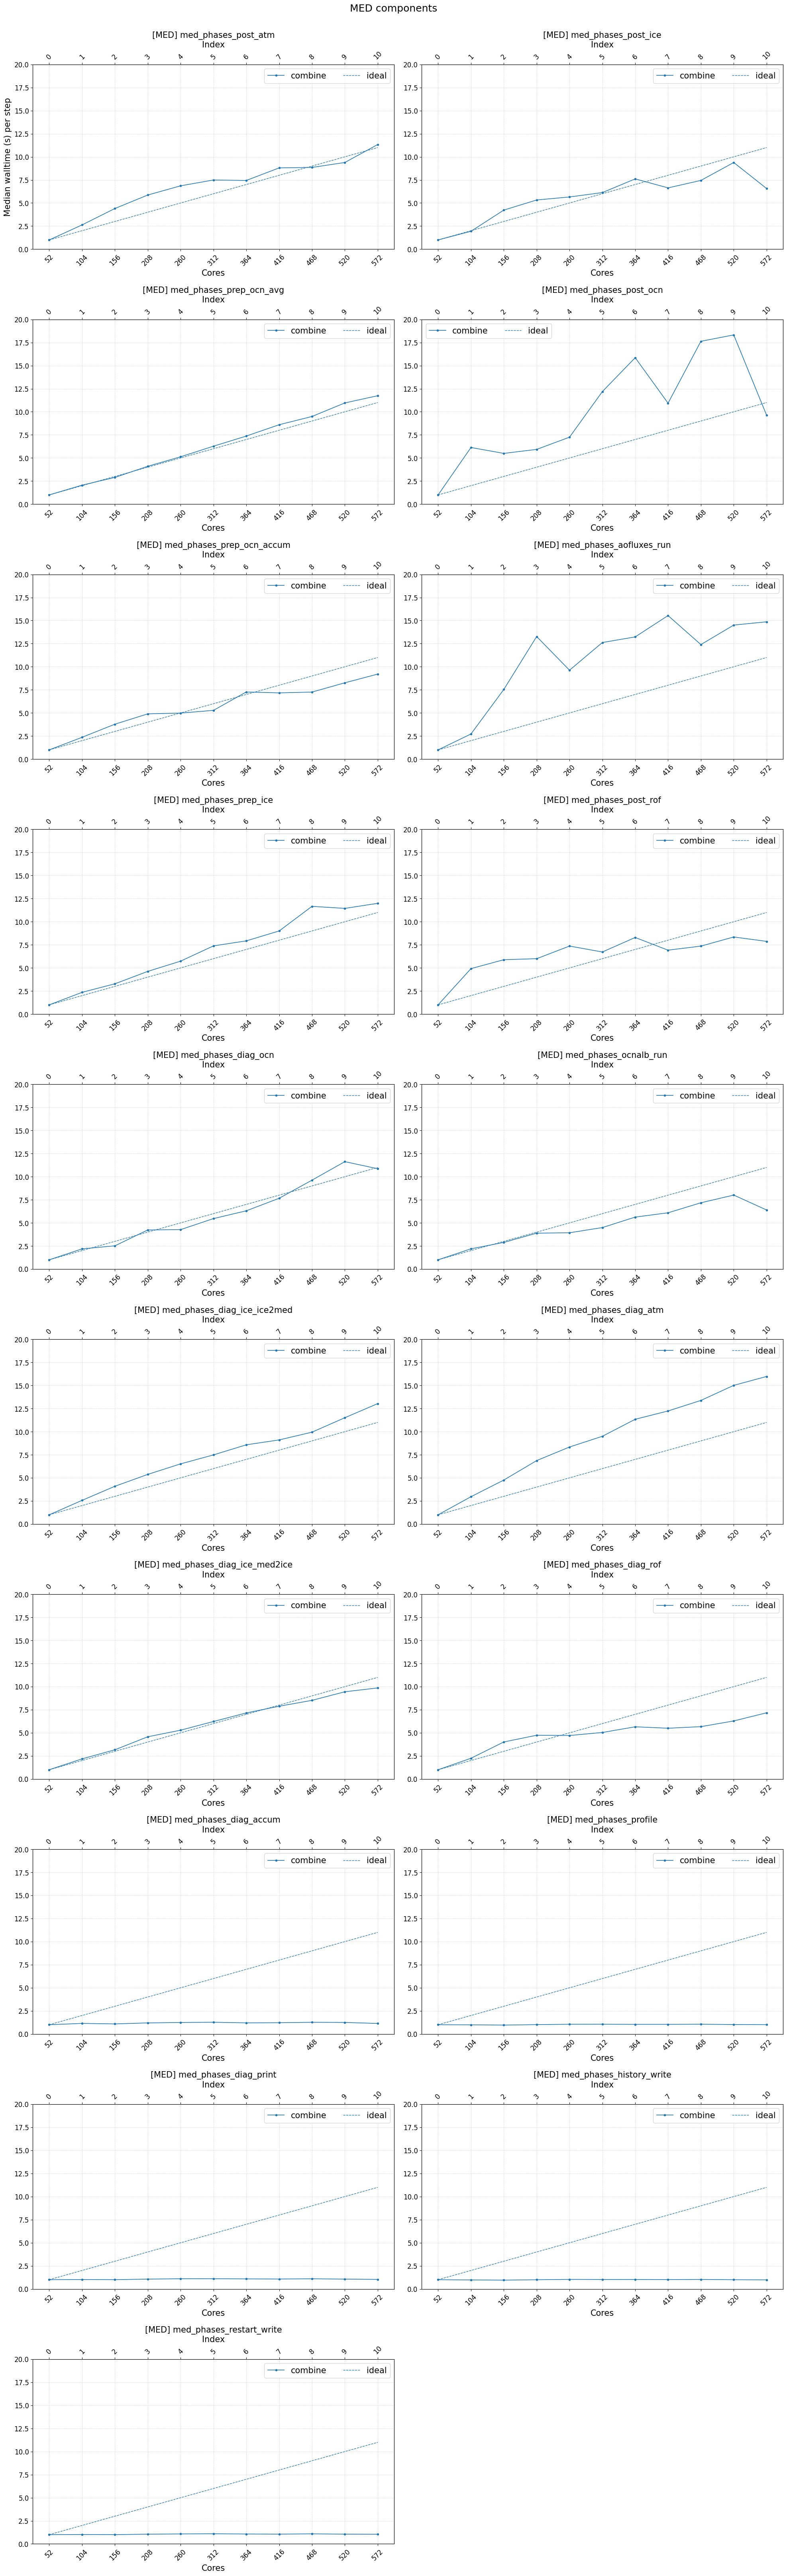

In [27]:
plot_speedup_med = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Median walltime (s) per step",
    ylim=(0,20),
    loglog=False,
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="MED components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,66)
)

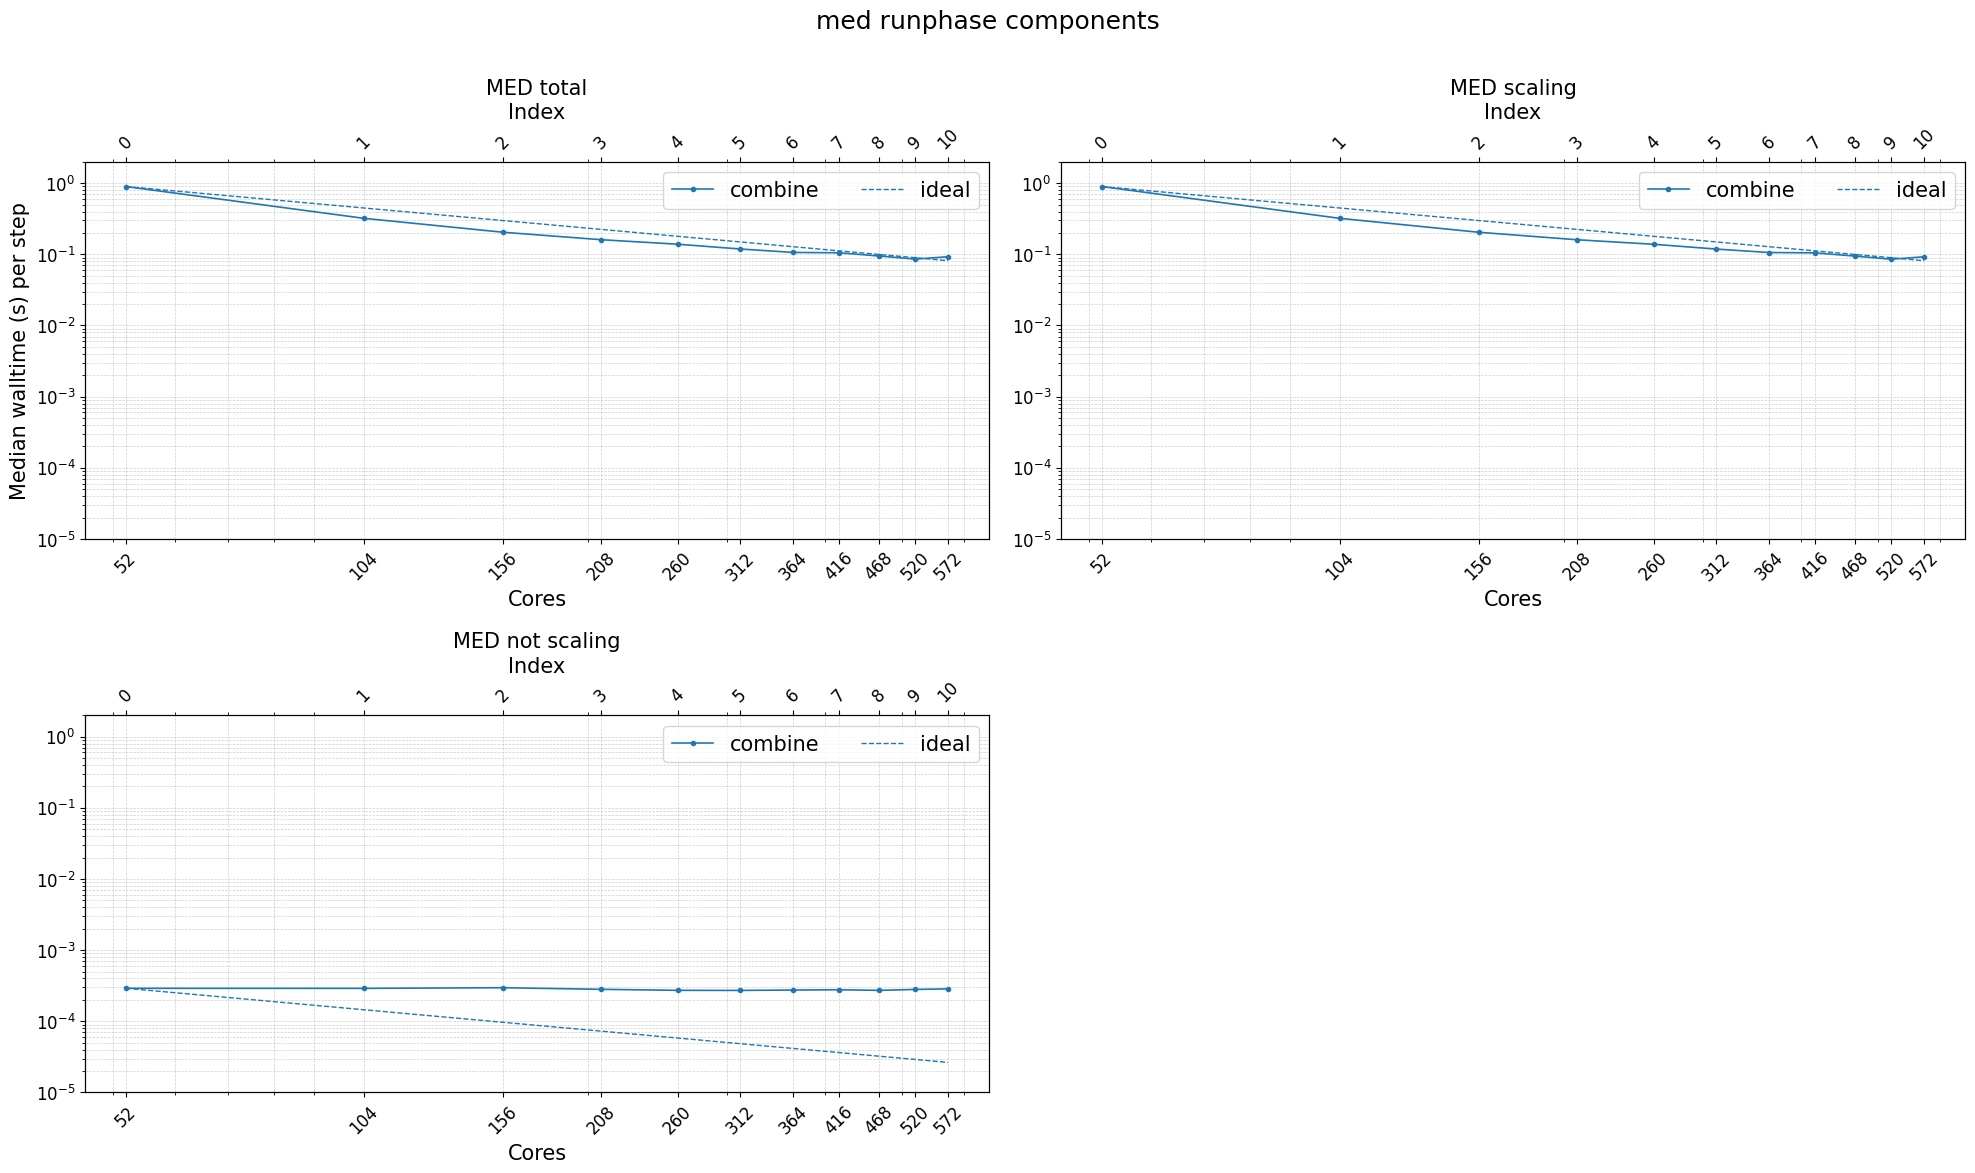

In [47]:
new_vars = {
    "MED total": [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
    ],
    "MED scaling": [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
    ],
    "MED not scaling": [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
    ],
}

pivot_scaling_med_post = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="Median walltime (s) per step",
    ylim=(1e-5,2),
    # loglog=False,
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med runphase components",
    #model_component=model_component,
    subplot_by_component=True,
    figsize=(20,12),
    new_vars=new_vars,
)


In [49]:
pivot_scaling_med_post

MED total MED scaling MED not scaling
__output_name   combine     combine         combine
cores                                              
52             0.896727    0.896436        0.000291
104            0.321065    0.320775        0.000290
156            0.204744    0.204447        0.000297
208            0.160558    0.160277        0.000281
260            0.138787    0.138515        0.000273
312            0.118921    0.118649        0.000272
364            0.106393    0.106118        0.000275
416            0.105189    0.104912        0.000278
468            0.094764    0.094492        0.000272
520            0.085702    0.085421        0.000280
572            0.092565    0.092279        0.000286

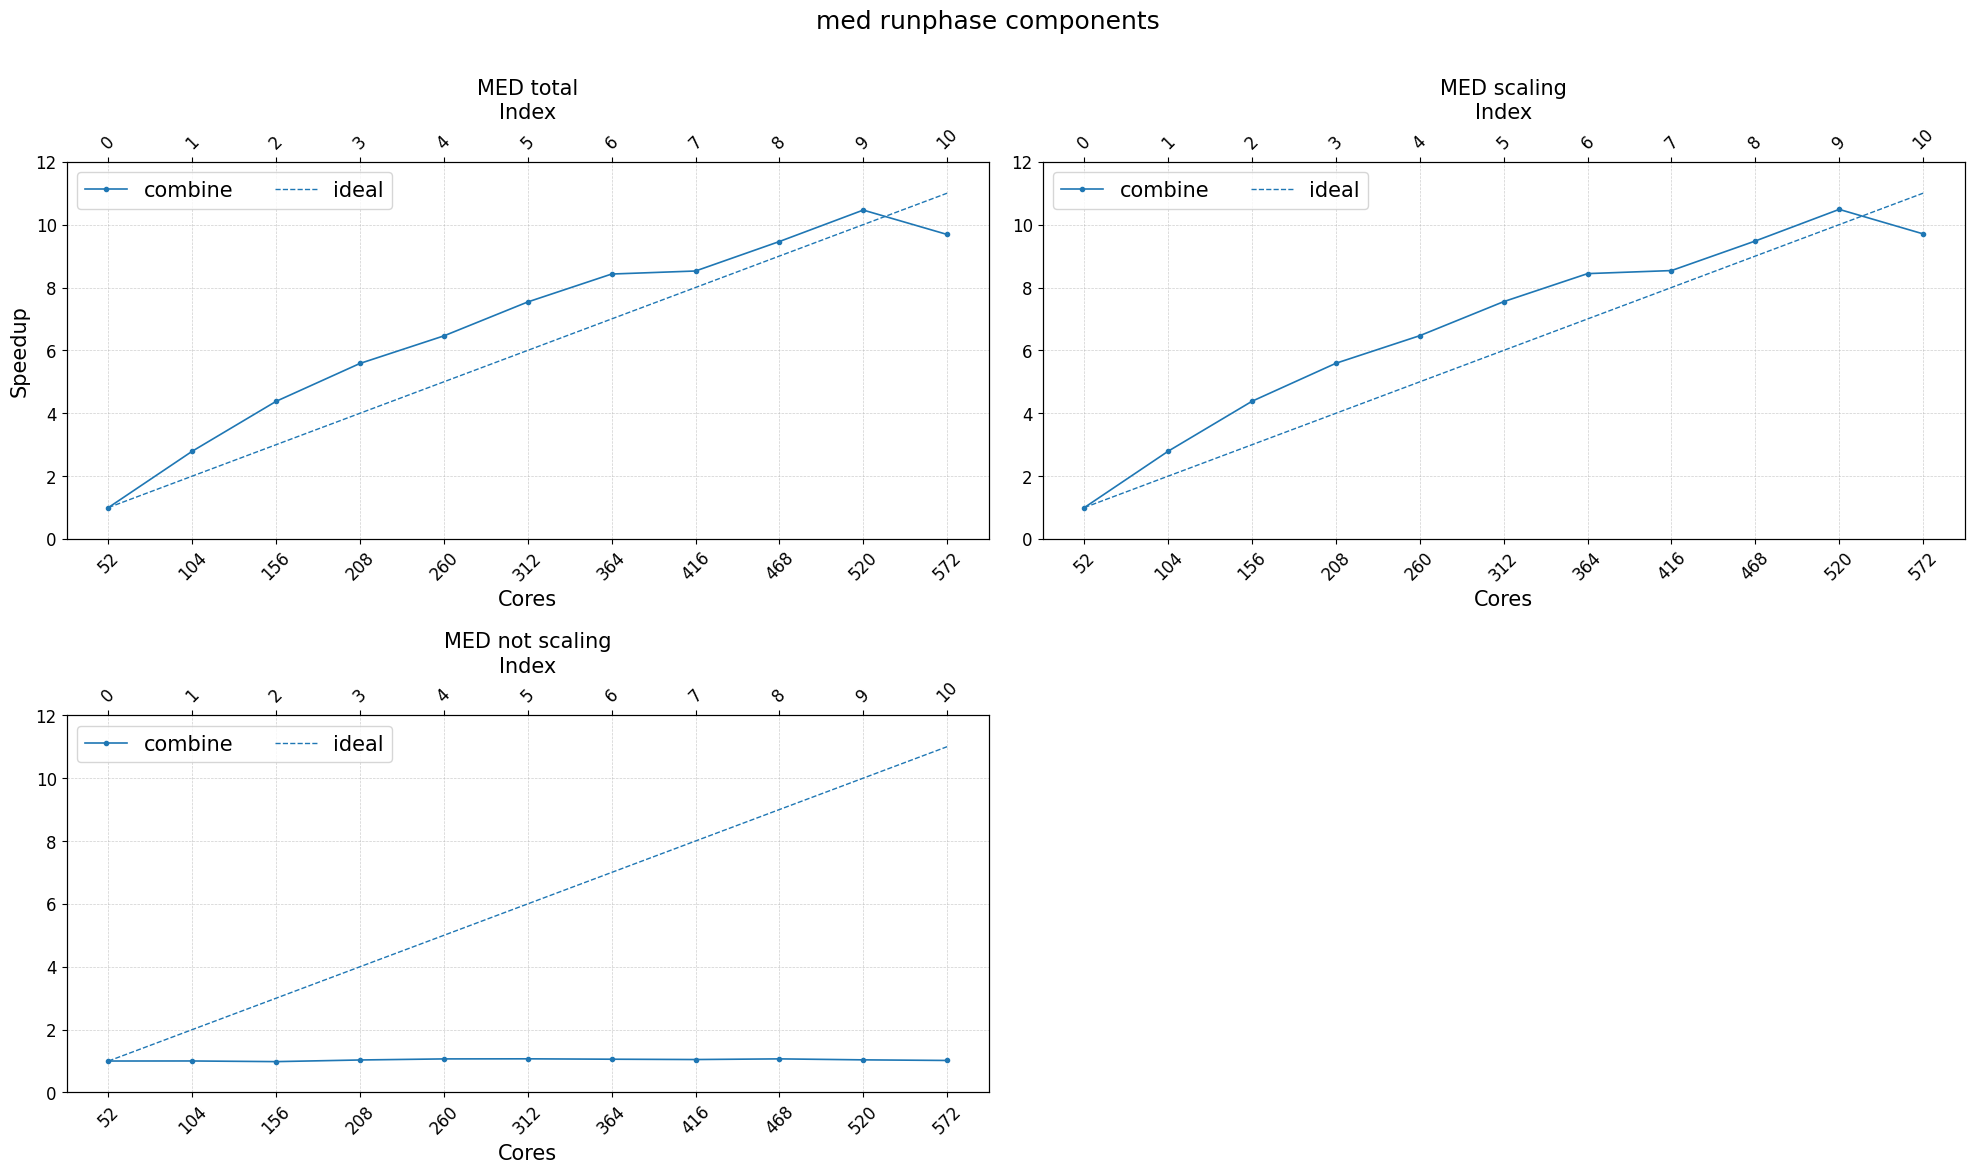

In [30]:
pivot_speedup_med_post = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylim=(0,12),
    loglog=False,
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med runphase components",
    #model_component=model_component,
    subplot_by_component=True,
    figsize=(20,12),
    new_vars=new_vars,
)


In [31]:
pivot_speedup_med_post

MED total MED scaling MED not scaling
         combine     combine         combine
cores                                       
52      1.000000    1.000000        1.000000
104     2.792975    2.794128        1.001639
156     4.379747    4.383253        0.980867
208     5.585065    5.590741        1.033263
260     6.461164    6.468663        1.067294
312     7.540508    7.551034        1.070080
364     8.428458    8.441971        1.057705
416     8.524897    8.538876        1.047506
468     9.462752    9.479889        1.068278
520    10.463364   10.485297        1.037241
572     9.687546    9.706611        1.018091

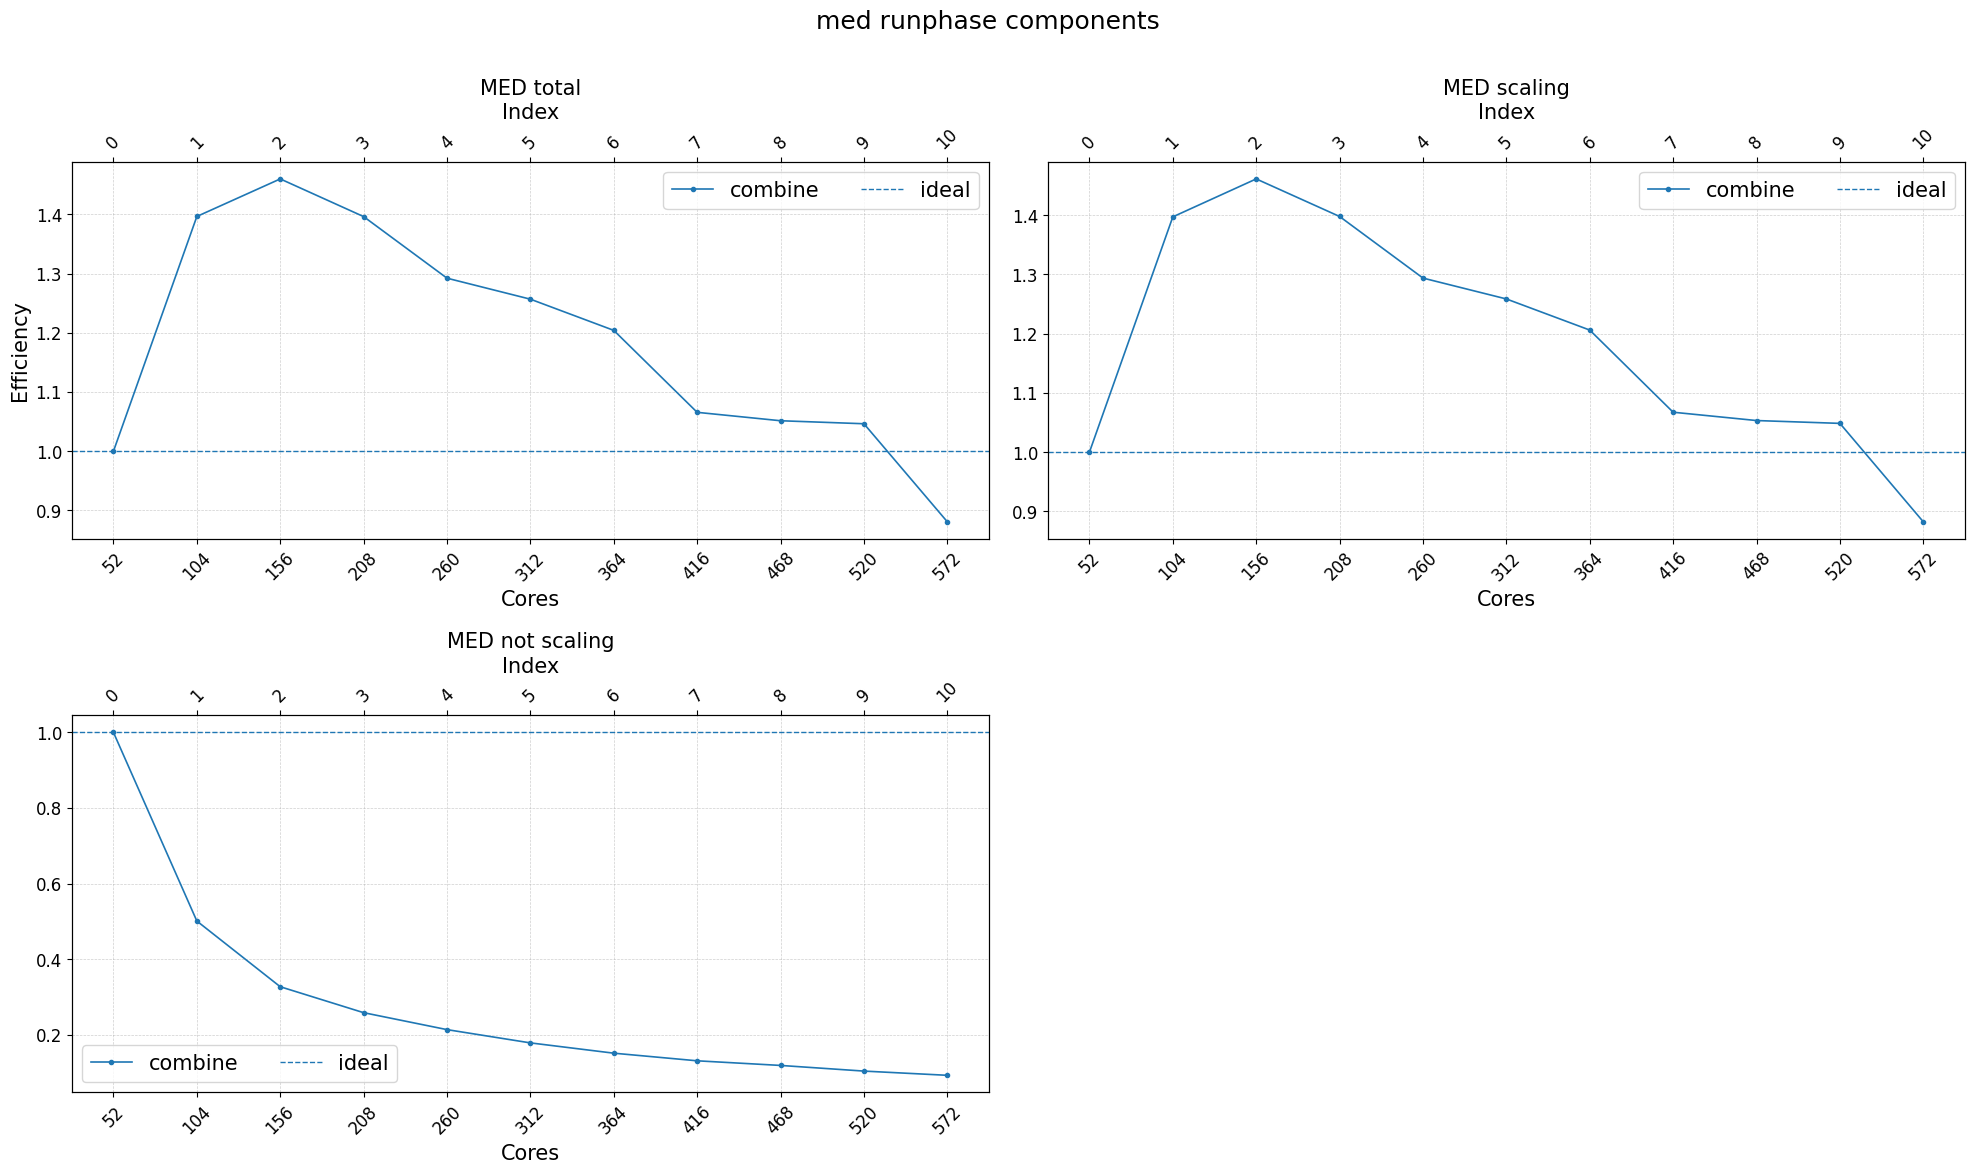

In [32]:
pivot_efficiency_med_post = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med runphase components",
    #model_component=model_component,
    subplot_by_component=True,
    figsize=(20,12),
    new_vars=new_vars,
)


In [33]:
pivot_efficiency_med_post

MED total MED scaling MED not scaling
        combine     combine         combine
cores                                      
52     1.000000    1.000000        1.000000
104    1.396488    1.397064        0.500820
156    1.459916    1.461084        0.326956
208    1.396266    1.397685        0.258316
260    1.292233    1.293733        0.213459
312    1.256751    1.258506        0.178347
364    1.204065    1.205996        0.151101
416    1.065612    1.067360        0.130938
468    1.051417    1.053321        0.118698
520    1.046336    1.048530        0.103724
572    0.880686    0.882419        0.092554

## med initialisation

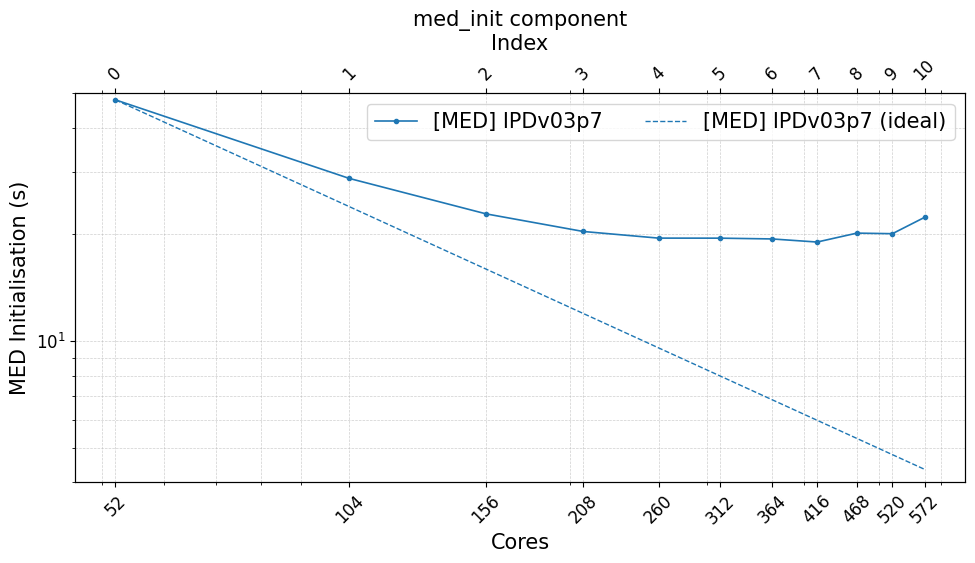

In [34]:
cores = [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572]
model_component = (
    "[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7",
)

pivot_scaling_med_init = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    ylabel="MED Initialisation (s)",
    ylim=(4,50),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med_init component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [35]:
pivot_scaling_med_init

[MED] IPDv03p7
__output_name        combine
cores                       
52                 47.911190
104                28.769597
156                22.857707
208                20.391641
260                19.531787
312                19.525841
364                19.427546
416                19.039990
468                20.175099
520                20.100019
572                22.346213

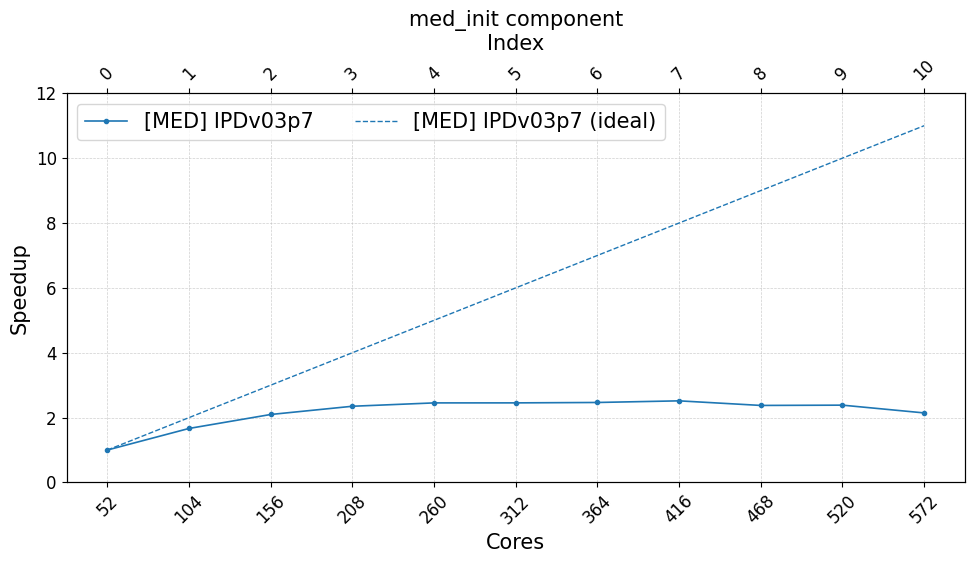

In [36]:
pivot_speedup_med_init = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    loglog=False,
    ylim=(0,12),
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med_init component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [37]:
pivot_speedup_med_init

[MED] IPDv03p7
             combine
cores               
52          1.000000
104         1.665341
156         2.096063
208         2.349550
260         2.452985
312         2.453732
364         2.466147
416         2.516345
468         2.374769
520         2.383639
572         2.144041

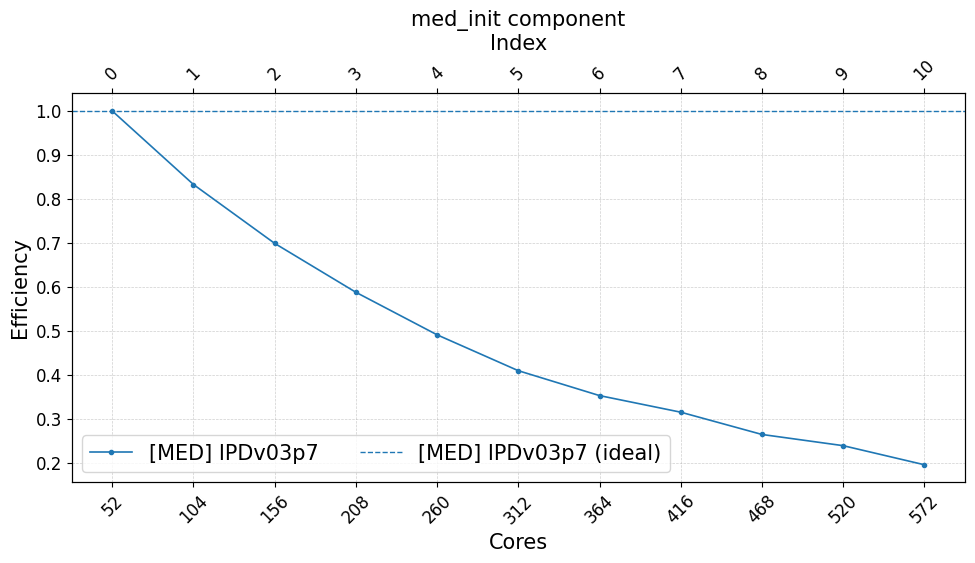

In [38]:
pivot_efficiency_med_init = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med_init component",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(10,6)
)

In [39]:
pivot_efficiency_med_init

[MED] IPDv03p7
             combine
cores               
52          1.000000
104         0.832670
156         0.698688
208         0.587388
260         0.490597
312         0.408955
364         0.352307
416         0.314543
468         0.263863
520         0.238364
572         0.194913